In [1]:
import pandas as pd
import numpy as np

from pathlib import Path
# import seaborn as sns
from tqdm import tqdm

# import matplotlib.pyplot as plt
# import matplotlib
# %matplotlib inline


import backtrader as bt
import backtrader.indicators as btind

import datetime

### Load Data

In [2]:
db_path = Path("../../Data/Crypto/crypto_min.h5")
db_path

WindowsPath('../../Data/Crypto/crypto_min.h5')

In [4]:
df_pv = pd.read_hdf(db_path)

df_pv = df_pv.reset_index()
df_pv = df_pv.set_index('time')

df_pv.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1295515 entries, 2022-01-01 00:01:00 to 2022-06-30 00:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   id      1295515 non-null  object 
 1   low     1295515 non-null  float64
 2   high    1295515 non-null  float64
 3   open    1295515 non-null  float64
 4   close   1295515 non-null  float64
 5   volume  1295515 non-null  float64
dtypes: float64(5), object(1)
memory usage: 69.2+ MB


In [5]:
df_pv['id'].unique()

array(['BTC-USD', 'ETH-USD', 'SOL-USD', 'AVAX-USD', 'ADA-USD'],
      dtype=object)

In [6]:
df_pv

,id,low,high,open,close,volume
time,,,,,,
2022-01-01 00:01:00,BTC-USD,46228.0000,46327.6100,46244.6300,46301.2900,22.578581
2022-01-01 00:02:00,BTC-USD,46284.8100,46372.5500,46305.4400,46345.0800,38.435608
2022-01-01 00:03:00,BTC-USD,46299.9700,46377.1000,46345.0800,46320.3000,8.236354
2022-01-01 00:04:00,BTC-USD,46285.7000,46329.0900,46316.2400,46306.8900,16.319029
2022-01-01 00:05:00,BTC-USD,46268.2500,46422.9400,46315.1000,46413.8300,40.695435
...,...,...,...,...,...,...
2022-06-29 23:56:00,ADA-USD,0.4650,0.4656,0.4654,0.4651,45674.970000
2022-06-29 23:57:00,ADA-USD,0.4646,0.4655,0.4652,0.4650,96180.950000
2022-06-29 23:58:00,ADA-USD,0.4648,0.4661,0.4649,0.4657,32517.900000


In [47]:
df = df_pv[df_pv.id=='SOL-USD'][['close']].join(df_pv[df_pv.id=='ETH-USD'][['close']], rsuffix='2')
df['ratio'] = (df['close']/df['close2'])[df.index.normalize().unique()[1:]]
df = df.fillna(method='ffill').dropna()
df['spread'] = df['close'] - df['ratio'] * df['close2']

In [56]:
df_pv[df_pv.id=='SOL-USD'].join(df[['spread']], how='inner').drop(columns=['id']).to_csv('../../Data/sol.csv')

### Preparation Func

In [57]:
ticker_list = df_pv['id'].unique()


## in case add self-defined features
class PandasData_more(bt.feeds.PandasData):
    lines = ('spread', ) # add self-defined data

    params=(
        ('spread', -1),
           )


def feedData(cerebro, df, ticker):
    data = pd.DataFrame(index=df_pv.index.unique())

    if 'spread' in df.columns:
        # process the data into bt format
        df = df[['open','high','low','close','volume', 'spread']]
        data_ = pd.merge(data, df, left_index=True, right_index=True, how='left')

        # process nan
        data_.loc[:,'volume'] = data_.loc[:, 'volume'].fillna(0)
        data_.loc[:,['open','high','low','close']] = data_.loc[:,['open','high','low','close']].fillna(method='pad')
        data_.loc[:,['open','high','low','close']] = data_.loc[:,['open','high','low','close']].fillna(0)
        data_['spread'] = data_['spread'].fillna(0)

        
        # feed data
        datafeed = PandasData_more(dataname=data_,
                                    fromdate=data_.index[0], todate=data_.index[-1]
                                    )
    
    else:
        # process the data into bt format
        df = df[['open','high','low','close','volume']]
        data_ = pd.merge(data, df, left_index=True, right_index=True, how='left')

        # process nan
        data_.loc[:,'volume'] = data_.loc[:, 'volume'].fillna(0)
        data_.loc[:,['open','high','low','close']] = data_.loc[:,['open','high','low','close']].fillna(method='pad')
        data_.loc[:,['open','high','low','close']] = data_.loc[:,['open','high','low','close']].fillna(0)

        # feed data
        datafeed = bt.feeds.PandasData(dataname=data_,
                                    fromdate=data_.index[0], todate=data_.index[-1]
                                    )

    cerebro.adddata(datafeed, name=ticker) # match ticker
    print(f"{ticker} Done !")

##### Unit Test

In [8]:
class TestStrategy(bt.Strategy):
    def __init__(self):

        print("Ticker:", self.datas[0]._name) 
        print("Fields: ", self.datas[0].lines.getlinealiases())
        print("Close: ", self.datas[0].lines.close[0])
        print("Low: ", self.datas[0].lines.low[0])
        print("Volume: ", self.datas[0].lines.volume[0])
        print("Datetime: ", self.datas[0].lines.datetime[0])

    
    def next(self):
        for ticker in self.getdatanames():
            if ticker == 'ETH-USD':
                data = self.getdatabyname(ticker)
            
                print("Datetime: ", bt.num2date(data.lines[6][0]), "| Close: ", data.lines.close[0])
                # print(bt.num2date(self.datas[0].lines[6][0]), self.datas[0].lines.close[0])

cerebro_test = bt.Cerebro()
ticker_list = ['BTC-USD', 'ETH-USD']
# datafeed = bt.feeds.PandasData(dataname=df_pv.query(f"id=='{ticker}'")[['open','high','low','close','volume']])
# cerebro_test.adddata(datafeed, name=ticker)

feedData(cerebro_test, ticker_list)

cerebro_test.addstrategy(TestStrategy)
result = cerebro_test.run()

BTC-USD Done !
ETH-USD Done !
Ticker: BTC-USD
Fields:  ('close', 'low', 'high', 'open', 'volume', 'openinterest', 'datetime', 'pe')
Close:  31207.87
Low:  31124.12
Volume:  142.61262293
Datetime:  738286.5784722222
Datetime:  2022-01-01 00:01:00 | Close:  3690.48
Datetime:  2022-01-01 00:02:00 | Close:  3691.71
Datetime:  2022-01-01 00:03:00 | Close:  3689.63
Datetime:  2022-01-01 00:04:00 | Close:  3688.78
Datetime:  2022-01-01 00:05:00 | Close:  3697.84
Datetime:  2022-01-01 00:06:00 | Close:  3704.01
Datetime:  2022-01-01 00:07:00 | Close:  3697.84
Datetime:  2022-01-01 00:08:00 | Close:  3695.97
Datetime:  2022-01-01 00:09:00 | Close:  3696.76
Datetime:  2022-01-01 00:10:00 | Close:  3698.32
Datetime:  2022-01-01 00:11:00 | Close:  3691.14
Datetime:  2022-01-01 00:12:00 | Close:  3687.73
Datetime:  2022-01-01 00:13:00 | Close:  3691.01
Datetime:  2022-01-01 00:14:00 | Close:  3691.29
Datetime:  2022-01-01 00:15:00 | Close:  3691.49
Datetime:  2022-01-01 00:16:00 | Close:  3690.41
D

KeyboardInterrupt: 

### Inititalize cerebro 

In [110]:
cerebro = bt.Cerebro(optdatas=True, optreturn=True)

### Feed Data

In [111]:
ticker_list = df_pv['id'].unique()
ticker_list = ticker_list[1:3]
ticker_list

array(['ETH-USD', 'SOL-USD'], dtype=object)

In [112]:
df_sol = pd.read_csv('../../Data/sol.csv', index_col=0, parse_dates=True)
df_eth = df_pv[df_pv.id=='ETH-USD']

In [113]:
feedData(cerebro, df_sol, 'SOL')
feedData(cerebro, df_eth, 'ETH')

SOL Done !
ETH Done !


In [114]:
# feedData(cerebro, ticker_list)

### Config

In [115]:
# initial cash
cerebro.broker.setcash(300_000.0)

class CommInfoFractional(bt.CommissionInfo):
    def getsize(self, price, cash):
        '''Returns fractional size for cash operation @price'''
        return self.p.leverage * (cash / price)

comminfo = CommInfoFractional(commission=0.0003)
cerebro.broker.addcommissioninfo(comminfo)

### Strategy

In [116]:
class DefaultStrategy(bt.Strategy):
    params = (
        ('period1', 2),
        ('period2', 40),
        ('openlong', -0.015),
        ('openshort', 0.015),
        ('closelong', -0.005),
        ('closeshort', 0.005), 
        ('notional_per_trade', 60_000),
        ('tickersnum', 1)    
    )

    # trading logs
    def log(self, txt, dt=None):           
        dt = dt or self.datas[0].datetime.datetime(0)
        print('%s, %s' % (dt.isoformat(), txt))

    
    
    def notify_order(self, order):
        # free cash
        total_cash = self.broker.getcash()
        # ticker's existing size
        hold_size = self.broker.getposition(order.data).size

        total_hold = 0
        for ticker in self.getdatanames(): 
            total_hold += self.broker.getposition(self.getdatabyname(ticker)).price * self.broker.getposition(self.getdatabyname(ticker)).size
            
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed, order.Canceled, order.Margin]:
            if order.isbuy():
                self.log(
                        'BUY EXECUTED, ref:%.0f, Price: %.2f, Cost: %.2f, Comm %.2f, Size: %.2f, Stock: %s, HoldSize: %.2f' %
                        (order.ref, 
                        order.executed.price, 
                        order.executed.value, 
                        order.executed.comm, 
                        order.executed.size, 
                        order.data._name,
                        hold_size
                        ))
                self.log('Total_Cash: %.2f, Total_Hold: %.2f, Total_Value: %.2f' %
                    (total_cash, total_hold, total_cash+total_hold)
                    )
            else: # Sell
                self.log('SELL EXECUTED, ref:%.0f, Price: %.2f, Cost: %.2f, Comm %.2f, Size: %.2f, Stock: %s, HoldSize: %.2f' %
                            (order.ref,
                            order.executed.price,
                            order.executed.value,
                            order.executed.comm,
                            order.executed.size,
                            order.data._name,
                            hold_size
                            ))
                self.log('Total_Cash: %.2f, Total_Hold: %.2f, Total_Value: %.2f' %
                    (total_cash, total_hold, total_cash+total_hold)
                    )

    # def start(self):
    #     self.mystats = csv.writer(open("mystats.csv", "w"))
    #     self.mystats.writerow(['datetime',
    #                            'drawdown', 'maxdrawdown',
    #                            'timereturn',
    #                            'value', 'cash'])

    def __init__(self):
        self.order = None
        self.status = 0


        for ticker in self.getdatanames():
            data = self.getdatabyname(ticker)
            # construct ExponentialMovingAverage
            data.lines.ema1 = bt.ind.EMA(data.lines.close, period = self.p.period1)
            data.lines.ema2 = bt.ind.EMA(data.lines.close, period = self.p.period2)
            data.lines.signal = data.lines.ema1 - data.lines.ema2


    def next(self):
        etfcum_target = 0
        adjust_flag = False


        for ticker in self.getdatanames():
            if ticker == 'ETH':
                continue

            data = self.getdatabyname(ticker)

            cur_position = self.getposition(data)

            if not cur_position:  # no position
                if data.lines.signal[0] > self.params.openshort * data.close[0] and \
                   data.lines.signal[-1] < self.params.openshort * data.close[0] and \
                   self.broker.getcash() > self.params.notional_per_trade:
                    flag = -1
                    adjust_flag = True
                    # self.sell(data = data, size = self.params.notional_per_trade / data.close[0], exectype=bt.Order.Market)
                    

                elif data.lines.signal[0] < self.params.openlong * data.close[0] and \
                     data.lines.signal[-1] > self.params.openlong * data.close[0] and \
                     self.broker.getcash() > self.params.notional_per_trade:
                    flag = 1
                    adjust_flag = True
                    # self.buy(data = data, size = self.params.notional_per_trade / data.close[0], exectype=bt.Order.Market)
                else:
                    continue

                order = self.order_target_value(
                    data=data, target=flag * self.params.notional_per_trade)
                etfcum_target -= self.params.notional_per_trade * flag

                self.log(
                    f"Open Signal, Ticker: {ticker:4}, Price: {data.close[0]:.2f}, Signal: {data.lines.signal[0]:.2f}, Target: {flag * self.params.notional_per_trade:.2f}")

            elif cur_position.size > 0 and data.lines.signal[0] > self.params.closelong * data.close[0] and data.lines.signal[-1] < self.params.closelong * data.close[0]:
                order = self.order_target_value(data=data, target=0)
                adjust_flag = True

                self.log(
                    f"Close Signal, Ticker: {ticker:4}, Price: {data.close[0]:.2f}, Signal: {data.lines.signal[0]:.2f}, Target: {0:.2f}")

            elif cur_position.size < 0 and data.lines.signal[0] < self.params.closeshort * data.close[0] and data.lines.signal[-1] > self.params.closeshort * data.close[0]:
                order = self.order_target_value(data=data, target=0)
                adjust_flag = True

                self.log(
                    f"Close Signal, Ticker: {ticker:4}, Price: {data.close[0]:.2f}, Signal: {data.lines.signal[0]:.2f}, Target: {0:.2f}")
            
            else:
                etfcum_target -= cur_position.size * \
                    cur_position.price 

        if adjust_flag:
        # if True:
            data = self.getdatabyname(ticker)
            order = self.order_target_value(
                data=data, target=etfcum_target)
            self.log(
                f"Adjust Signal, ETF: {ticker:4}, Price: {data.close[0]:.2f}, Target: {etfcum_target:.2f}")

In [117]:
# cerebro.optstrategy(DefaultStrategy, period1=range(20, 25, 5), period2=range(60, 70, 10))
cerebro.addstrategy(DefaultStrategy)

# add observer
# cerebro.addobserver(bt.observers.Broker)
# cerebro.addobserver(bt.observers.Trades)
# cerebro.addobserver(bt.observers.BuySell)
# cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# add analyzer
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='_TimeReturn')
cerebro.addanalyzer(bt.analyzers.Returns, _name='_Returns', tann=252)

cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='_SharpeRatio', timeframe=bt.TimeFrame.Days, annualize=True, riskfreerate=0) 


cerebro.addanalyzer(bt.analyzers.DrawDown, _name='_DrawDown')

results = cerebro.run()
# results = cerebro.run(maxcpus=2)


2022-01-02T00:00:00, Open Signal, Ticker: SOL , Price: 178.92, Signal: 110.55, Target: -60000.00
2022-01-02T00:00:00, Adjust Signal, ETF: ETH , Price: 3767.30, Target: 60000.00
2022-01-02T00:01:00, SELL EXECUTED, ref:8243, Price: 178.89, Cost: -59989.94, Comm 18.00, Size: -335.35, Stock: SOL, HoldSize: -335.35
2022-01-02T00:01:00, Total_Cash: 299953.94, Total_Hold: 10.06, Total_Value: 299964.00
2022-01-02T00:01:00, BUY EXECUTED, ref:8244, Price: 3767.30, Cost: 60000.00, Comm 18.00, Size: 15.93, Stock: ETH, HoldSize: 15.93
2022-01-02T00:01:00, Total_Cash: 299953.94, Total_Hold: 10.06, Total_Value: 299964.00
2022-01-02T01:42:00, Close Signal, Ticker: SOL , Price: 178.49, Signal: 0.84, Target: 0.00
2022-01-02T01:42:00, Adjust Signal, ETF: ETH , Price: 3746.28, Target: 0.00
2022-01-02T01:43:00, BUY EXECUTED, ref:8245, Price: 178.49, Cost: -59989.94, Comm 17.96, Size: 335.35, Stock: SOL, HoldSize: 0.00
2022-01-02T01:43:00, Total_Cash: 299727.51, Total_Hold: 0.00, Total_Value: 299727.51
2022

In [118]:
def get_my_analyzer(result):
    analyzer = {}

    analyzer['annual_return'] = result.analyzers._Returns.get_analysis()['rnorm']
    analyzer['annual_return(%)'] = result.analyzers._Returns.get_analysis()['rnorm100']

    analyzer['drawdown'] = result.analyzers._DrawDown.get_analysis()['max']['drawdown'] * (-1)

    analyzer['sharperatio'] = result.analyzers._SharpeRatio.get_analysis()['sharperatio']
    
    return analyzer

ret = []
for result in results:
    ret.append(get_my_analyzer(result))
    
pd.DataFrame(ret)

,annual_return,annual_return(%),drawdown,sharperatio
0,0.069931,6.993103,-3.075578,1.743239


In [119]:
import warnings

warnings.filterwarnings("ignore")

def pnl_curve(name, results):
    # 提取收益序列
    pnl = pd.Series(results[0].analyzers._TimeReturn.get_analysis())
    # 计算累计收益
    cumulative = (pnl + 1).cumprod()
    # 计算回撤序列
    max_return = cumulative.cummax()
    drawdown = (cumulative - max_return) / max_return
    # 计算收益评价指标
    import pyfolio as pf
    # 按年统计收益指标
    perf_stats_year = (pnl).groupby(pnl.index.to_period('y')).apply(lambda data: pf.timeseries.perf_stats(data)).unstack()
    # 统计所有时间段的收益指标
    perf_stats_all = pf.timeseries.perf_stats((pnl)).to_frame(name='all')
    perf_stats = pd.concat([perf_stats_year, perf_stats_all.T], axis=0)
    perf_stats_ = round(perf_stats,4).reset_index()


    # 绘制图形
    import matplotlib.pyplot as plt
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
    import matplotlib.ticker as ticker  # 导入设置坐标轴的模块
    # plt.rcParams['figure.figsize'] = 30, 15
    plt.style.use('seaborn')  # plt.style.use('dark_background')


    fig, (ax0, ax1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[1.5, 4]}, figsize=(20,14))
    cols_names = ['date', 'Annual\nreturn', 'Cumulative\nreturns', 'Annual\nvolatility',
        'Sharpe\nratio', 'Calmar\nratio', 'Stability', 'Max\ndrawdown',
        'Omega\nratio', 'Sortino\nratio', 'Skew', 'Kurtosis', 'Tail\nratio',
        'Daily value\nat risk']

    # 绘制表格
    ax0.set_axis_off()  # 除去坐标轴
    table = ax0.table(cellText = perf_stats_.values, 
                    bbox=(0,0,1,1),  # 设置表格位置， (x0, y0, width, height)
                    rowLoc = 'right',  # 行标题居中
                    cellLoc='right' ,
                    colLabels = cols_names, # 设置列标题
                    colLoc = 'right',  # 列标题居中
                    edges = 'open' # 不显示表格边框
                    )
    table.set_fontsize(13)

    # 绘制累计收益曲线
    ax2 = ax1.twinx()
    ax1.yaxis.set_ticks_position('right') # 将回撤曲线的 y 轴移至右侧
    ax2.yaxis.set_ticks_position('left') # 将累计收益曲线的 y 轴移至左侧
    # 绘制回撤曲线
    drawdown.plot.area(ax=ax1, label='drawdown (right)', rot=0, alpha=0.3, fontsize=13, grid=False)
    # 绘制累计收益曲线
    (cumulative).plot(ax=ax2, color='#F1C40F' , lw=3.0, label='cumret (left)', rot=0, fontsize=13, grid=False)
    # 不然 x 轴留有空白
    ax2.set_xbound(lower=cumulative.index.min(), upper=cumulative.index.max())
    # 主轴定位器：每 5 个月显示一个日期：根据具体天数来做排版
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(100)) 
    # 同时绘制双轴的图例
    h1,l1 = ax1.get_legend_handles_labels()
    h2,l2 = ax2.get_legend_handles_labels()
    plt.legend(h1+h2,l1+l2, fontsize=12, loc='upper left', ncol=1)

    fig.tight_layout() # 规整排版

    result = results[0]
    openlong = result.params.openlong
    openshort = result.params.openshort
    
    closelong = result.params.closelong
    closeshort = result.params.closeshort

    file_path = Path("plot")
    plt.savefig(file_path / f"cumret_{name}_{openlong:.1f}_{closelong:.1f}.png")
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'plot\\cumret_ETH_-0.0_-0.0.png'

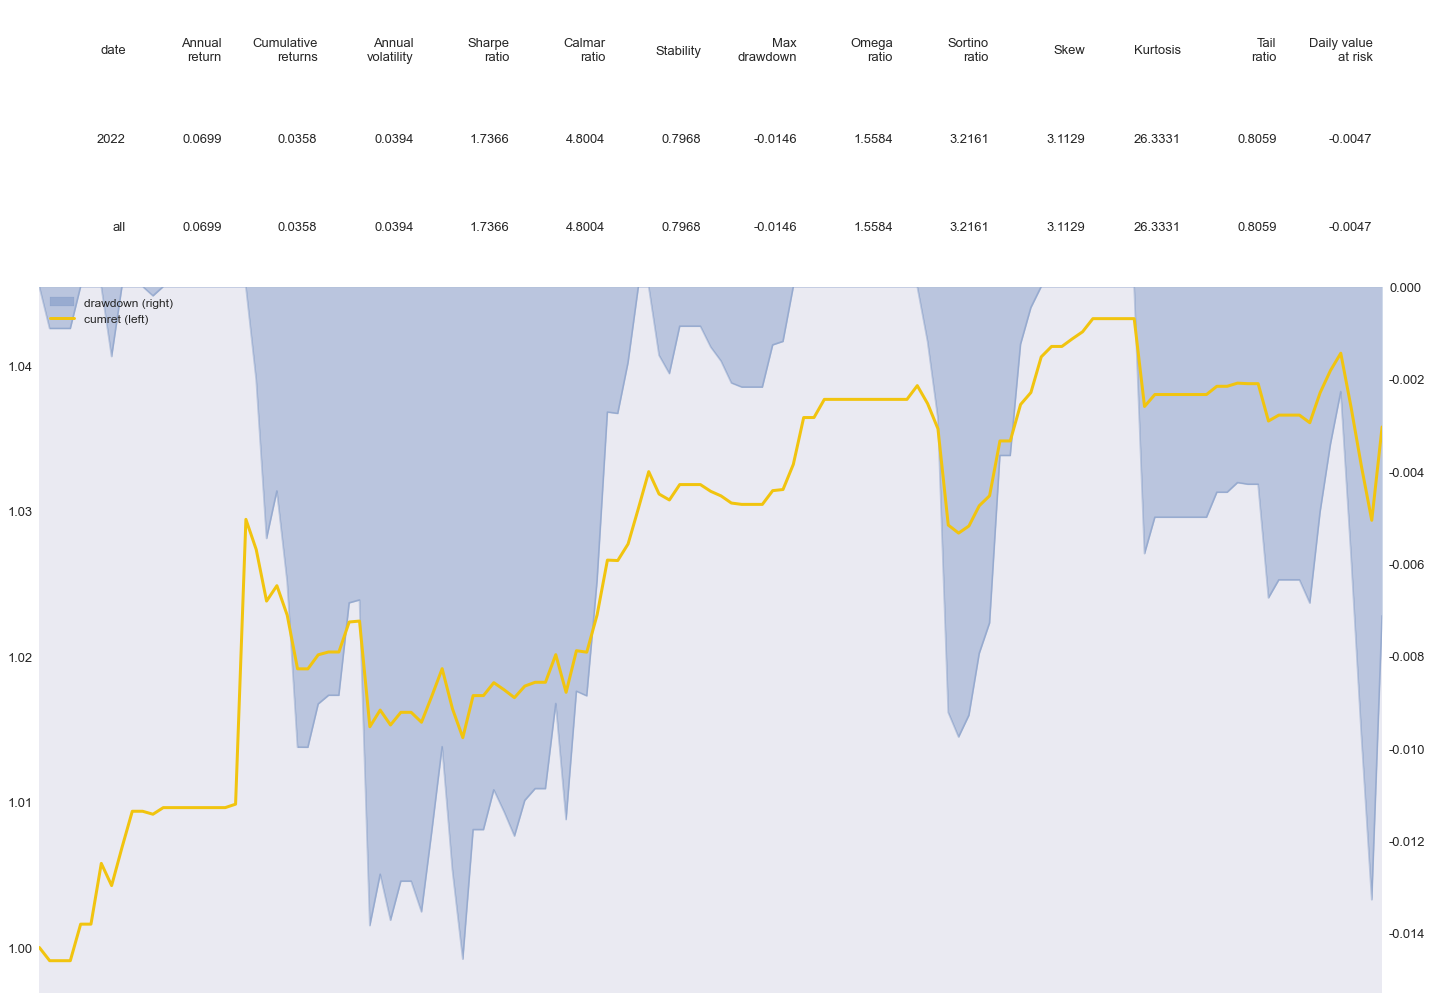

In [120]:
pnl_curve(f"ETH", results)

In [79]:
df_sol

,low,high,open,close,volume,spread
time,,,,,,
2022-01-02 00:00:00,178.92,179.39,179.19,178.92,2709.226,0.000000
2022-01-02 00:01:00,178.69,179.02,178.89,178.69,805.508,-0.081347
2022-01-02 00:02:00,178.40,178.75,178.71,178.68,1635.586,-0.234301
2022-01-02 00:03:00,178.52,178.81,178.70,178.60,925.137,-0.350395
2022-01-02 00:04:00,178.59,178.82,178.62,178.74,933.372,-0.300632
...,...,...,...,...,...,...
2022-06-29 23:56:00,33.87,33.94,33.87,33.88,724.193,-0.005386
2022-06-29 23:57:00,33.84,33.93,33.88,33.89,2285.807,0.010787
2022-06-29 23:58:00,33.88,34.04,33.88,34.01,3204.380,0.085724


In [80]:
df_eth

,id,low,high,open,close,volume
time,,,,,,
2022-01-01 00:01:00,ETH-USD,3680.47,3691.42,3683.50,3690.48,235.332604
2022-01-01 00:02:00,ETH-USD,3685.75,3693.47,3690.27,3691.71,152.966873
2022-01-01 00:03:00,ETH-USD,3687.74,3693.69,3691.70,3689.63,108.386096
2022-01-01 00:04:00,ETH-USD,3686.24,3689.94,3689.62,3688.78,109.894593
2022-01-01 00:05:00,ETH-USD,3684.96,3698.00,3688.78,3697.84,144.824999
...,...,...,...,...,...,...
2022-06-29 23:56:00,ETH-USD,1097.39,1098.52,1097.39,1097.85,116.197452
2022-06-29 23:57:00,ETH-USD,1096.83,1098.36,1097.85,1097.65,123.459003
2022-06-29 23:58:00,ETH-USD,1097.48,1099.75,1097.65,1099.11,160.532857
